

## 1. Expansion of the GoogLeNet Model

The research paper introduces the architecture of a deep convolutional neural network called "Inception," with a specific variant named "GoogLeNet." The Inception architecture was designed to improve the utilization of computing resources within the network, allowing for increased depth and width while keeping the computational budget constant.

### (i) Mathematical and Logical Intuition:

**Sparse Structure Approximation:**
The Inception architecture incorporates a sparse structure inspired by the Hebbian principle, suggesting that neurons exhibiting simultaneous activity should form sparse connections. This design, influenced by Arora et al.'s work, aims to create an efficient convolutional vision network with selectively sparse links. The architecture seeks to approximate the optimal sparse structure, where “neurons that fire together, wire together”, promoting meaningful associations for enhanced efficiency and effective representation within the network.

**Layer-by-Layer Construction:**
The network is constructed layer by layer by analyzing the correlation statistics of the activations of the last layer. Clusters of units with high correlation form the units of the next layer, and these are connected to units in the previous layer. The goal is to maintain a sparse structure.

**Inception Modules:**
The architecture introduces "Inception modules" that are stacked on top of each other. These modules consist of convolutions with filter sizes of 1x1, 3x3, and 5x5. The use of multiple filter sizes allows the network to capture features at different scales simultaneously.

### (ii) Architecture:

**Basic Structure:**
The Inception architecture is a deep neural network designed for computer vision tasks. It uses a layer-by-layer construction, stacking Inception modules on top of each other. The network is about 22 layers deep (or 27 layers if counting pooling layers).

**Inception Modules & Dimension Reduction:**
The key building blocks are the Inception modules, which consist of convolutions with filter sizes of 1x1, 3x3, and 5x5. The output of these modules is concatenated to form the input for the next stage. To handle computational complexity, dimension reduction is applied using 1x1 convolutions before the more expensive 3x3 and 5x5 convolutions. This reduction is based on the use of rectified linear activation, serving a dual purpose.

**Pooling Path:**
The architecture incorporates an alternative parallel pooling path in each stage to improve performance. Max-pooling layers with stride 2 are occasionally used to halve the resolution of the grid.

**Auxiliary Classifiers:**
To encourage discrimination in lower stages and improve gradient signal propagation, auxiliary classifiers are added to intermediate layers. During training, their loss is added to the total loss of the network with a discount weight, but they are discarded at inference time.

**Training Methodology:**
The network is trained using asynchronous stochastic gradient descent with momentum, fixed learning rate schedule, and Polyak averaging. Multiple models are trained independently and ensembled during testing, using an aggressive cropping approach and averaging softmax probabilities over multiple crops and classifiers.

**Overall,**
The architecture is designed to efficiently use computational resources, maintain a sparse structure, and leverage features at different scales for improved performance in image recognition and object detection tasks.


## 2. Inception Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

# Function to create an Inception module
def inception_module(x, filters):
    conv1x1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = layers.Conv2D(filters[1], (3, 3), padding='same', activation='relu')(x)
    conv5x5 = layers.Conv2D(filters[2], (5, 5), padding='same', activation='relu')(x)
    maxpool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_conv1x1 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(maxpool)

    return layers.concatenate([conv1x1, conv3x3, conv5x5, pool_conv1x1], axis=-1)

# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Apply data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(x_train)

x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

# Define the Inception model with increased complexity
input_shape = (32, 32, 3)
inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Increase model complexity
x = inception_module(x, [64, 128, 32, 32])
x = layers.Dropout(0.4)(x)
x = inception_module(x, [128, 256, 64, 64])
x = layers.MaxPooling2D((2, 2))(x)

# Additional dense layer
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.6)(x)

outputs = layers.Dense(10, activation='softmax')(x)

# Create the model
model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model with a learning rate scheduler
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with data augmentation and learning rate scheduling
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=30,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

# Save the model to Google Drive
model.save('inception_model5.h5')

# Save training history to a text file on Google Drive
with open('inception_model_training_history.txt', 'w') as file:
    file.write(str(history.history))

## 3. Accuracy, Drawbacks & Suggestions

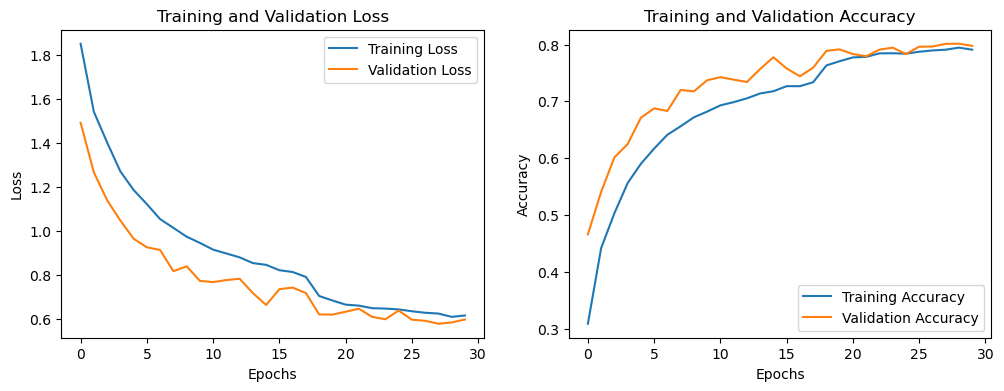

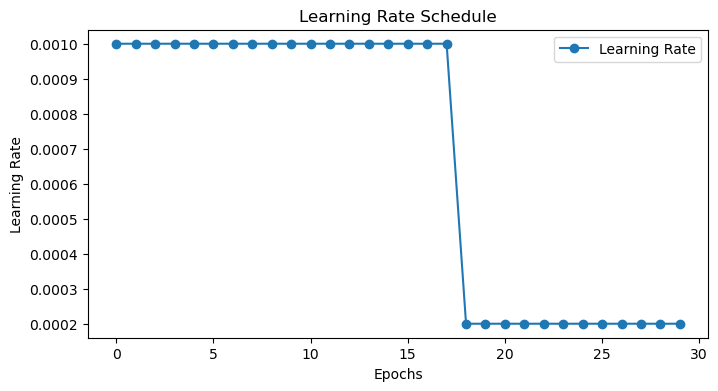

In [1]:
import matplotlib.pyplot as plt

# Read the content from the text file
with open('inception_model_training_history.txt', 'r') as file:
    history_str = file.read()

# Convert the string to a dictionary using eval
history = eval(history_str)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Display the learning rate over epochs
plt.figure(figsize=(8, 4))
plt.plot(history['lr'], label='Learning Rate', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()

# Show the plots
plt.show()

### (i) Accuracy:

**Almost 80 percen test accuracy with 0.596427857875824 validation loss**

The accuracy of the model during training shows an increasing trend, reaching around 79.1% at the end. The validation accuracy also demonstrates improvement, reaching approximately 79.8%. This indicates that the model is learning and generalizing well.

In the process, we have tried different hyperparameters and used techniques like dropout layers, data augmentation & learning rate scheduling to avoid overfitting and increase performance on test set.

### (ii) Drawbacks and suggestions for improvement:

**Validation Loss Fluctuations:**
There are fluctuations in validation loss. This could be addressed by exploring different optimization algorithms.

**Low Initial Accuracy & Model Complexity:**
The initial accuracy is relatively low. Can consider refining the model architecture or increasing complexity if the dataset allows.

The model is already quite complex with the Inception modules and the training provess takes a long time. However, increasing the complexity might result in increased performance. 

**Learning rate:**
Experimenting with different settings to find the optimal learning rate schedule for the problem at hand might make the model perform better.

**Evaluation:**
While the model's performance on the test set is evaluated, to ensure that the model's generalization to unseen data is robust, can explore techniques like k-fold cross-validation to get a more reliable estimate of the model's performance.

## Object Detection

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from keras.models import load_model
from keras.preprocessing import image

model_path = "inception_model5.h5"
model = load_model(model_path)

cifar10_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()

    img = cv2.resize(frame, (32, 32))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)

    label = cifar10_labels[predicted_class]
    cv2.putText(frame, f'Predicted: {label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow('Real-time Object Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### Some of the object detection results

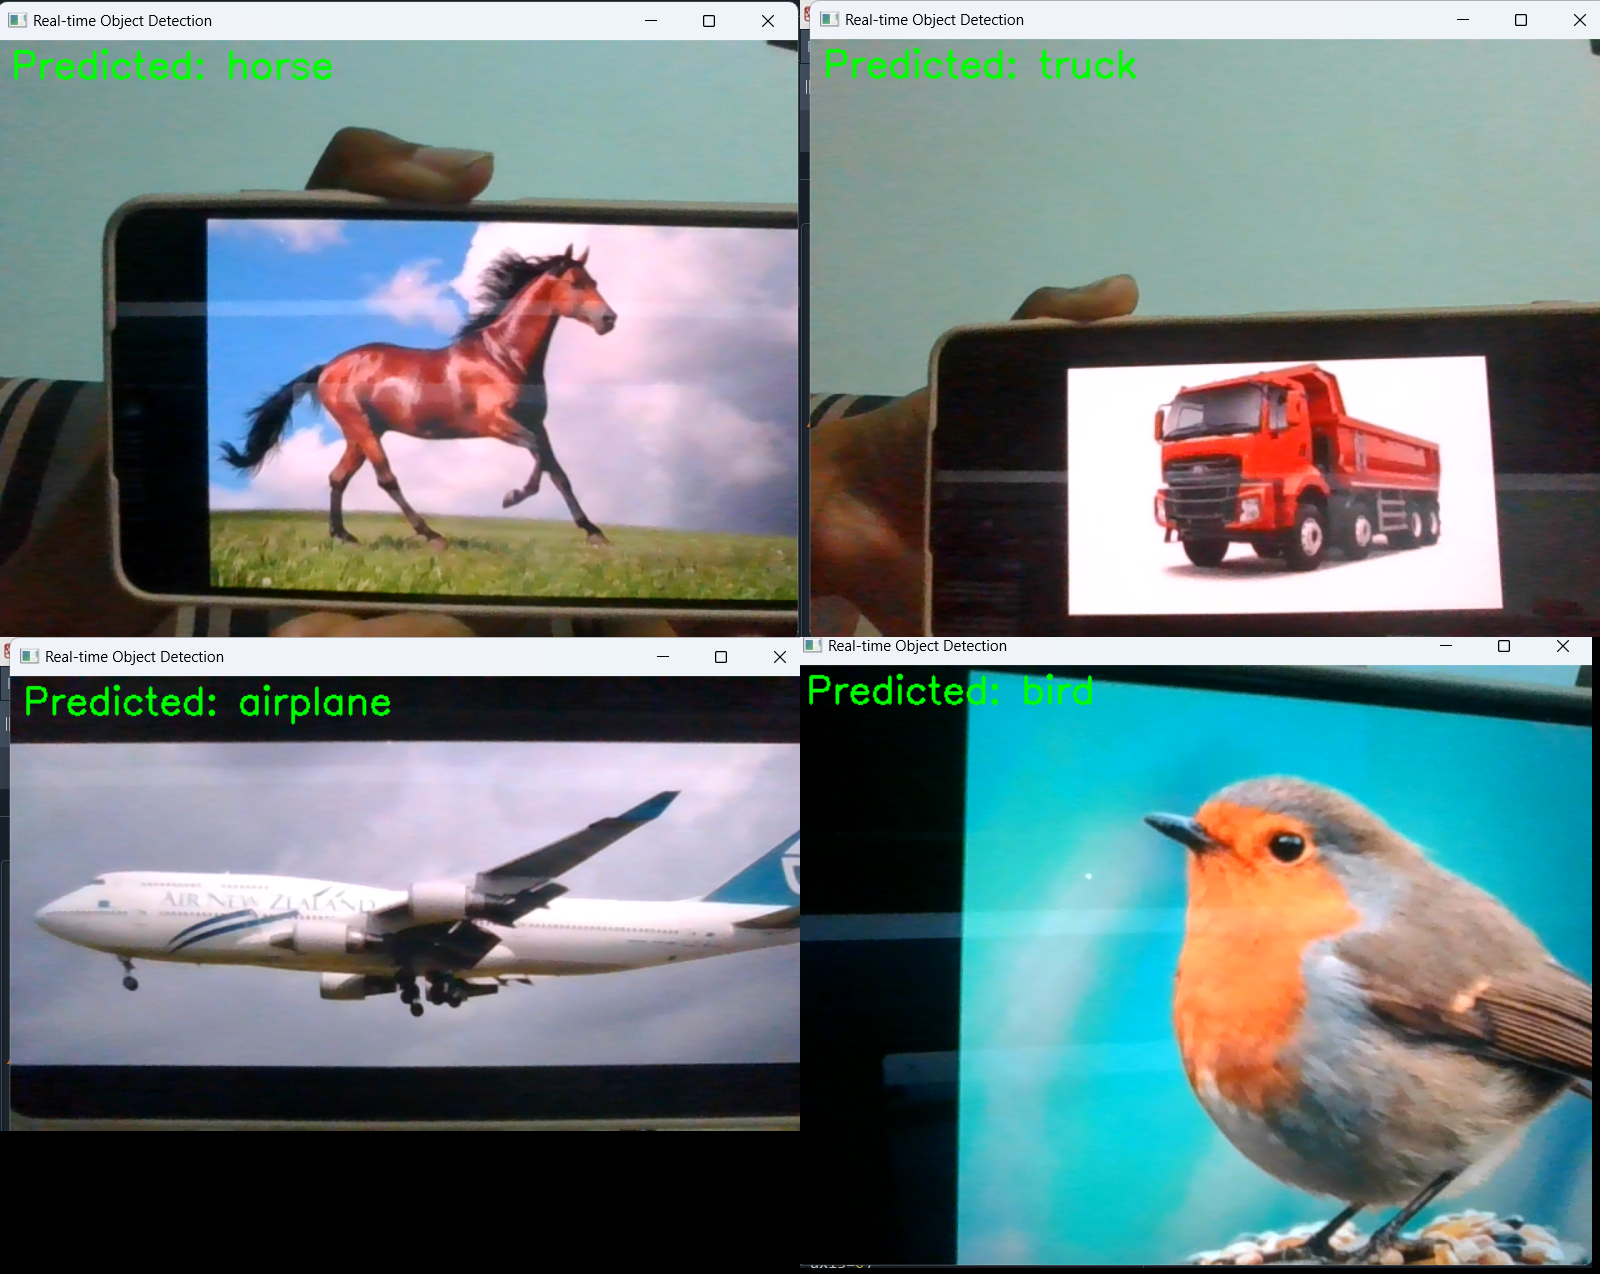

In [2]:
from PIL import Image
import IPython.display as display

def display_images_in_grid(image_paths):
    images = [Image.open(image_path) for image_path in image_paths]
    width, height = images[0].size
    grid_image = Image.new('RGB', (2 * width, 2 * height))

    for i in range(len(images)):
        row = i // 2
        col = i % 2
        grid_image.paste(images[i], (col * width, row * height))
    display.display(grid_image)

image_paths = [
    "images/image1.png",
    "images/image2.png",
    "images/image3.png",
    "images/image4.png"
]
display_images_in_grid(image_paths)